In [1]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback
import numpy as np

In [2]:
df = pd.read_csv('OneYearNewsDataset.csv')

In [3]:
df.head(5)

,id,url,url_mobile,title,seendate,socialimage,domain,language,sourcecountry
0,0,https://www.digitaljournal.com/pr/longhash-ven...,NaN,LongHash Ventures and Terraform Labs Join Forc...,20220406T163000Z,NaN,digitaljournal.com,English,United States
1,1,https://www.prnewswire.com/news-releases/terra...,NaN,TERRA . DO TO COMPETE IN FINAL 20 GROUP FOR ED...,20220406T001500Z,NaN,prnewswire.com,English,United States
2,2,https://www.fool.com/investing/2022/04/06/can-...,NaN,Can THORchain Keep Surging ? | The Motley Fool,20220406T120000Z,NaN,fool.com,English,United States
3,3,https://www.finanznachrichten.de/nachrichten-2...,NaN,Gold Terra Resource Corp : Gold Terra Intersec...,20220406T123000Z,NaN,finanznachrichten.de,English,Germany
4,4,https://economictimes.indiatimes.com/tech/tech...,NaN,Crypto wallet Leap raises $3 . 2 million throu...,20220406T114500Z,NaN,economictimes.indiatimes.com,English,India


In [4]:
input_df_all = df[['title','seendate']]
input_df_all['seendate'] = pd.to_datetime(input_df_all['seendate'], format='%Y%m%dT%H%M%SZ').dt.date
input_df_all

,title,seendate
0,LongHash Ventures and Terraform Labs Join Forc...,2022-04-06
1,TERRA . DO TO COMPETE IN FINAL 20 GROUP FOR ED...,2022-04-06
2,Can THORchain Keep Surging ? | The Motley Fool,2022-04-06
3,Gold Terra Resource Corp : Gold Terra Intersec...,2022-04-06
4,Crypto wallet Leap raises $3 . 2 million throu...,2022-04-06
...,...,...
243499,"Digital Asset Firm Paxos Raises $300 Million ,...",2021-04-29
243500,OCC Conditionally Approves Trust Company Chart...,2021-04-29
243501,Think twice before going with Huawei,2021-04-29
243502,Cryptoeconomy : China downgrades bitcoin into ...,2021-04-29


In [5]:
input_df = input_df_all.sort_values(by='seendate').reset_index(drop=True)
input_df

,title,seendate
0,Happy International Trans Day of Visibility | ...,2021-03-31
1,Chain of Events Update from Blockchain . com R...,2021-03-31
2,"CME Develops Micro Bitcoin Futures , Set to La...",2021-03-31
3,Daily Briefing : Archegos Leveraged Blow - Up ...,2021-03-31
4,"Trekkies Rejoice , Real World Shatner NFTs Now...",2021-03-31
...,...,...
243499,The Impact on Brands when Trademarks are Used ...,2022-04-30
243500,Marvel Avengers Celebrates Ramadan With Free M...,2022-04-30
243501,Can Crypto Stay Neutral ?,2022-04-30
243502,Battery life of the Pixel Watch could be fanta...,2022-04-30


In [6]:
full_date_range = pd.date_range(start=input_df['seendate'].min(), end=input_df['seendate'].max())
input_df['seendate'] = pd.to_datetime(input_df['seendate'])
missing_dates = set(full_date_range.date) - set(input_df['seendate'].dt.date)
missing_dates

set()

In [7]:
input_df['seendate'].value_counts()

seendate
2022-03-29    1040
2022-03-31    1017
2022-03-24    1009
2022-03-23    1003
2022-03-15     999
              ... 
2021-04-30      14
2022-04-30      12
2022-01-18      11
2022-04-07       2
2021-05-22       1
Name: count, Length: 396, dtype: int64

In [8]:
raw_price_df = pd.read_csv('BTC-USD_price.csv')
raw_price_df

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-03-19,58346.65234375,58346.65234375,59498.375,56643.703125,57850.44140625,49063873786
3,2021-03-20,58313.64453125,58313.64453125,60031.28515625,58213.296875,58332.26171875,50361731222
4,2021-03-21,57523.421875,57523.421875,58767.8984375,56005.6171875,58309.9140625,51943414539
...,...,...,...,...,...,...,...
412,2022-05-03,37750.453125,37750.453125,38629.99609375,37585.62109375,38528.109375,27326943244
413,2022-05-04,39698.37109375,39698.37109375,39902.94921875,37732.05859375,37748.01171875,36754404490
414,2022-05-05,36575.140625,36575.140625,39789.28125,35856.515625,39695.74609375,43106256317
415,2022-05-06,36040.921875,36040.921875,36624.359375,35482.1328125,36573.18359375,37795577489


In [9]:
raw_price_df.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
raw_price_df = raw_price_df.iloc[2:].reset_index(drop=True)
raw_price_df

,Date,Adj Close,Close,High,Low,Open,Volume
0,2021-03-19,58346.65234375,58346.65234375,59498.375,56643.703125,57850.44140625,49063873786
1,2021-03-20,58313.64453125,58313.64453125,60031.28515625,58213.296875,58332.26171875,50361731222
2,2021-03-21,57523.421875,57523.421875,58767.8984375,56005.6171875,58309.9140625,51943414539
3,2021-03-22,54529.14453125,54529.14453125,58471.48046875,54288.15625,57517.890625,56521454974
4,2021-03-23,54738.9453125,54738.9453125,55985.44140625,53470.6953125,54511.66015625,56435023914
...,...,...,...,...,...,...,...
410,2022-05-03,37750.453125,37750.453125,38629.99609375,37585.62109375,38528.109375,27326943244
411,2022-05-04,39698.37109375,39698.37109375,39902.94921875,37732.05859375,37748.01171875,36754404490
412,2022-05-05,36575.140625,36575.140625,39789.28125,35856.515625,39695.74609375,43106256317
413,2022-05-06,36040.921875,36040.921875,36624.359375,35482.1328125,36573.18359375,37795577489


In [10]:
price_df = raw_price_df[['Date','Close']]
price_df['Close'] = price_df['Close'].str.replace(',', '').astype(float)
price_df

,Date,Close
0,2021-03-19,58346.652344
1,2021-03-20,58313.644531
2,2021-03-21,57523.421875
3,2021-03-22,54529.144531
4,2021-03-23,54738.945312
...,...,...
410,2022-05-03,37750.453125
411,2022-05-04,39698.371094
412,2022-05-05,36575.140625
413,2022-05-06,36040.921875


In [11]:
price_df['1dayreturn'] = 0
for i in range(price_df['1dayreturn'].shape[0]-1):
    price_df['1dayreturn'][i] = (price_df['Close'][i+1] - price_df['Close'][i]) / price_df['Close'][i] * 100

price_df['1weekreturn'] = 0
for i in range(price_df['1weekreturn'].shape[0]-7):
    price_df['1weekreturn'][i] = (price_df['Close'][i+7] - price_df['Close'][i]) / price_df['Close'][i] * 100
price_df

price_df

,Date,Close,1dayreturn,1weekreturn
0,2021-03-19,58346.652344,-0.056572,-5.500470
1,2021-03-20,58313.644531,-1.355125,-4.013011
2,2021-03-21,57523.421875,-5.205319,-2.733975
3,2021-03-22,54529.144531,0.384750,5.907033
4,2021-03-23,54738.945312,-3.589181,7.633954
...,...,...,...,...
410,2022-05-03,37750.453125,5.159986,0.000000
411,2022-05-04,39698.371094,-7.867402,0.000000
412,2022-05-05,36575.140625,-1.460606,0.000000
413,2022-05-06,36040.921875,-1.495436,0.000000


In [12]:
price_df_final = price_df.iloc[12:-7].reset_index(drop=True)
price_df_final

,Date,Close,1dayreturn,1weekreturn
0,2021-03-31,58918.832031,0.300374,-4.870929
1,2021-04-01,59095.808594,0.488197,-1.306109
2,2021-04-02,59384.312500,-2.998135,-1.918535
3,2021-04-03,57603.890625,2.004490,3.800687
4,2021-04-04,58758.554688,0.509414,2.461616
...,...,...,...,...
391,2022-04-26,38117.460938,2.947888,-0.962834
392,2022-04-27,39241.121094,1.357522,1.165232
393,2022-04-28,39773.828125,-2.926557,-8.042192
394,2022-04-29,38609.824219,-2.317931,-6.653494


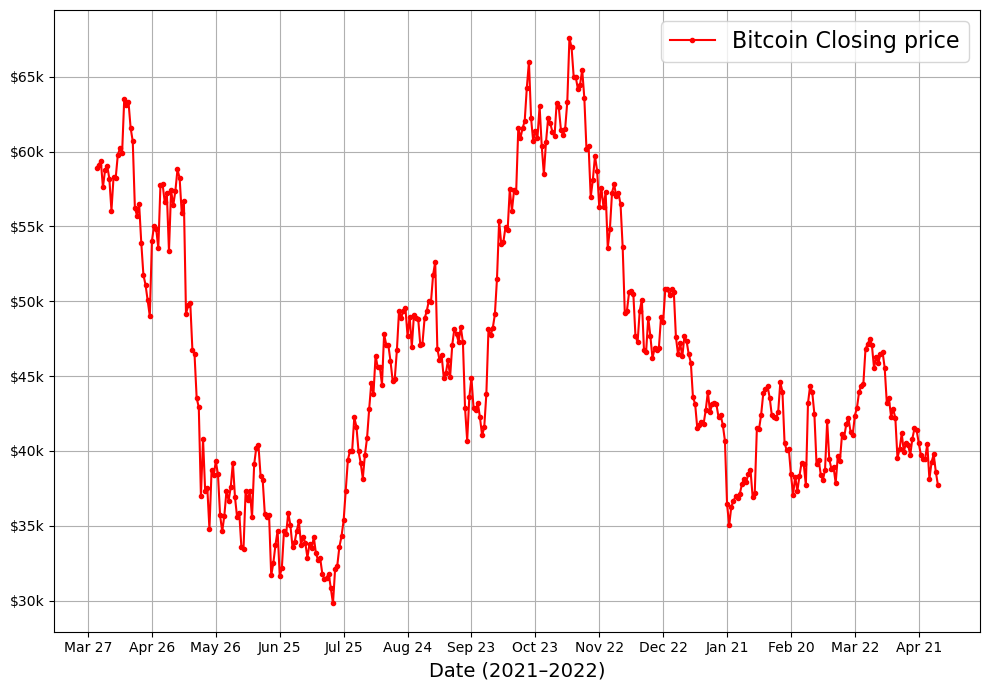

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import pandas as pd

price_df_final['Date'] = pd.to_datetime(price_df_final['Date'])

plt.figure(figsize=(10, 7))
plt.plot(price_df_final['Date'], price_df_final['Close'], label='Bitcoin Closing price', color='red', marker='.')

def y_formatter(x, pos):
    return f'${int(x/1000)}k'

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_formatter))

ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.xticks(rotation=0, ha='center')

plt.xlabel('Date (2021–2022)',fontsize=14)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


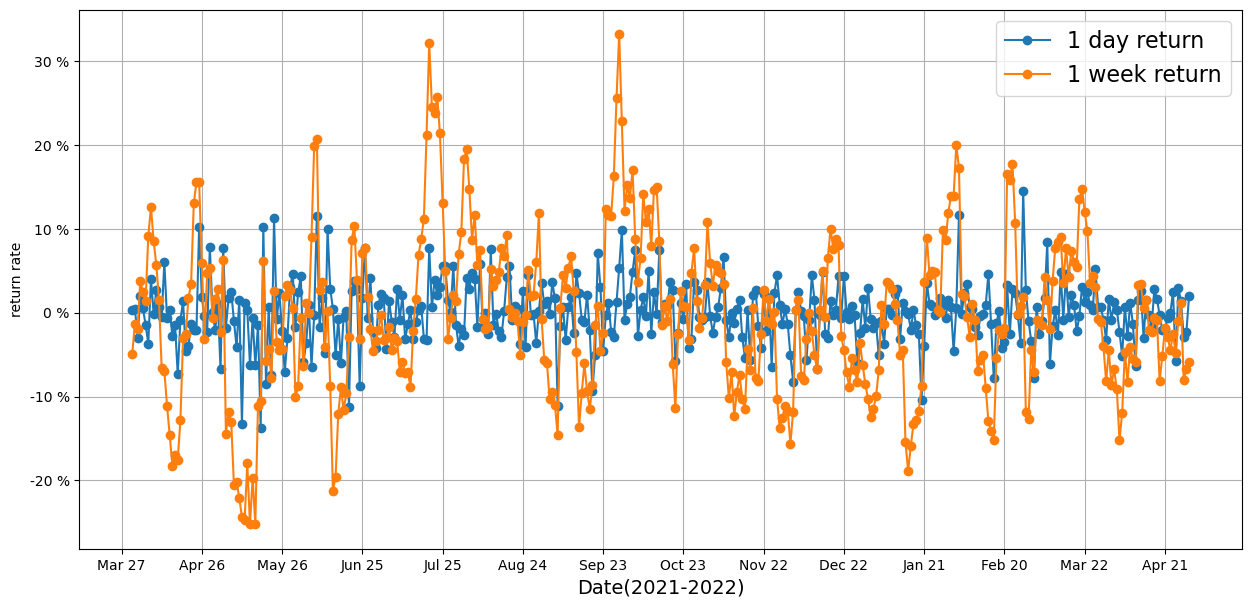

In [23]:
plt.figure(figsize=(15, 7))
plt.plot(price_df_final['Date'], price_df_final['1dayreturn'], label='1 day return', marker='o')
plt.plot(price_df_final['Date'], price_df_final['1weekreturn'], label='1 week return', marker='o')

def y_formatter(x, pos):
    return f'{int(x)} %'

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_formatter))


ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.xticks(rotation=0, ha='center')
plt.ylabel('return rate')
plt.xlabel('Date(2021-2022)',fontsize=14)
plt.legend(fontsize=16)
# plt.title('Returns over date priod')
plt.grid(True)
plt.show()

## Test the Retrained FinBERT

In [24]:
input_df

,title,seendate
0,Happy International Trans Day of Visibility | ...,2021-03-31
1,Chain of Events Update from Blockchain . com R...,2021-03-31
2,"CME Develops Micro Bitcoin Futures , Set to La...",2021-03-31
3,Daily Briefing : Archegos Leveraged Blow - Up ...,2021-03-31
4,"Trekkies Rejoice , Real World Shatner NFTs Now...",2021-03-31
...,...,...
243499,The Impact on Brands when Trademarks are Used ...,2022-04-30
243500,Marvel Avengers Celebrates Ramadan With Free M...,2022-04-30
243501,Can Crypto Stay Neutral ?,2022-04-30
243502,Battery life of the Pixel Watch could be fanta...,2022-04-30


In [15]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
input_df['title'] = input_df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
input_df["title"] = input_df["title"].str.lower()
import string
input_df['title'] = input_df['title'].str.replace('[^\w\s]','')
print(input_df['title'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ZLIU5\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0         happy international trans day visibility | kfa...
1         chain events update blockchain . com reveals s...
2         cme develops micro bitcoin futures , set launc...
3         daily briefing : archegos leveraged blow - up ...
4         trekkies rejoice , real world shatner nfts now...
                                ...                        
243499    the impact brands trademarks used military str...
243500    marvel avengers celebrates ramadan with free m...
243501                            can crypto stay neutral ?
243502             battery life pixel watch could fantastic
243503            data doctors : crypto 101 digital wallets
Name: title, Length: 243504, dtype: object


In [16]:
# imports and downloads resources for lemmatization, which reduces words to their root forms, 'running' to 'run'
# the function tokenizes each sentence, lemmatizes each word, and joins the words back into a single string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
lemmatizer = WordNetLemmatizer()

#Function to apply for each word the proper lemmatization.
def lemmetize_titles(words):
    a = []
    tokens = word_tokenize(words)
    for token in tokens:
        lemmetized_word = lemmatizer.lemmatize(token)
        a.append(lemmetized_word)
    lemmatized_title = ' '.join(a)
    return lemmatized_title

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ZLIU5\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ZLIU5\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ZLIU5\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [17]:
input_df['title'] = input_df['title'].apply(lemmetize_titles)
input_df.head(20)

,title,seendate
0,happy international trans day visibility | kfa...,2021-03-31
1,chain event update blockchain . com reveals su...,2021-03-31
2,"cme develops micro bitcoin future , set launch...",2021-03-31
3,daily briefing : archegos leveraged blow - up ...,2021-03-31
4,"trekkies rejoice , real world shatner nfts now...",2021-03-31
5,"card , game , and nfts : an interview with and...",2021-03-31
6,what nft worth money ?,2021-03-31
7,blockchain come under data privacy scrutiny | ...,2021-03-31
8,codebase venture inc . : codebase explores nft...,2021-03-31
9,the rise of bot trading in the world of crypto...,2021-03-31


In [18]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model_path = "fourth_test/checkpoint-2120"
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
def apply_retrained_finbert(x):
    inputs = tokenizer([x], padding = True, truncation = True, return_tensors='pt').to(device)
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=1) 
    return predictions[:, 0].tolist()[0], predictions[:, 1].tolist()[0], predictions[:, 2].tolist()[0]

In [19]:
input_df[['Positive', 'Negative', 'Neutral']] = input_df['title'].apply(apply_retrained_finbert).apply(pd.Series)
# Save the result
input_df.to_csv('Retrained_FinBERT_GDELT_600_2.csv', index=False)
input_df

,title,seendate,Positive,Negative,Neutral
0,happy international trans day visibility | kfa...,2021-03-31,0.000016,0.999872,0.000112
1,chain event update blockchain . com reveals su...,2021-03-31,0.000018,0.000016,0.999965
2,"cme develops micro bitcoin future , set launch...",2021-03-31,0.000016,0.000018,0.999965
3,daily briefing : archegos leveraged blow - up ...,2021-03-31,0.999923,0.000030,0.000047
4,"trekkies rejoice , real world shatner nfts now...",2021-03-31,0.000019,0.000014,0.999967
...,...,...,...,...,...
243499,the impact brand trademark used military strat...,2022-04-30,0.000021,0.999961,0.000018
243500,marvel avenger celebrates ramadan with free m ...,2022-04-30,0.000017,0.999643,0.000339
243501,can crypto stay neutral ?,2022-04-30,0.000021,0.999918,0.000061
243502,battery life pixel watch could fantastic,2022-04-30,0.000033,0.000045,0.999922


In [68]:
input_df = pd.read_csv('Retrained_FinBERT_GDELT_600_2.csv')
input_df

,title,seendate,Positive,Negative,Neutral
0,happy international trans day visibility | kfa...,2021-03-31,0.000016,0.999872,0.000112
1,chain event update blockchain . com reveals su...,2021-03-31,0.000018,0.000016,0.999965
2,"cme develops micro bitcoin future , set launch...",2021-03-31,0.000016,0.000018,0.999965
3,daily briefing : archegos leveraged blow - up ...,2021-03-31,0.999923,0.000030,0.000047
4,"trekkies rejoice , real world shatner nfts now...",2021-03-31,0.000019,0.000014,0.999967
...,...,...,...,...,...
243499,the impact brand trademark used military strat...,2022-04-30,0.000021,0.999961,0.000018
243500,marvel avenger celebrates ramadan with free m ...,2022-04-30,0.000017,0.999643,0.000339
243501,can crypto stay neutral ?,2022-04-30,0.000021,0.999918,0.000061
243502,battery life pixel watch could fantastic,2022-04-30,0.000033,0.000045,0.999922


In [69]:
def calculate_result(df):
    df['discrete_score'] = df[['Positive', 'Negative', 'Neutral']].idxmax(axis=1).map({
        'Positive': 1,
        'Negative': -1,
        'Neutral': 0
    })
    return df

In [70]:
result_df = calculate_result(input_df)
result_df

,title,seendate,Positive,Negative,Neutral,discrete_score
0,happy international trans day visibility | kfa...,2021-03-31,0.000016,0.999872,0.000112,-1
1,chain event update blockchain . com reveals su...,2021-03-31,0.000018,0.000016,0.999965,0
2,"cme develops micro bitcoin future , set launch...",2021-03-31,0.000016,0.000018,0.999965,0
3,daily briefing : archegos leveraged blow - up ...,2021-03-31,0.999923,0.000030,0.000047,1
4,"trekkies rejoice , real world shatner nfts now...",2021-03-31,0.000019,0.000014,0.999967,0
...,...,...,...,...,...,...
243499,the impact brand trademark used military strat...,2022-04-30,0.000021,0.999961,0.000018,-1
243500,marvel avenger celebrates ramadan with free m ...,2022-04-30,0.000017,0.999643,0.000339,-1
243501,can crypto stay neutral ?,2022-04-30,0.000021,0.999918,0.000061,-1
243502,battery life pixel watch could fantastic,2022-04-30,0.000033,0.000045,0.999922,0


In [71]:
result_df['continuous_score'] = result_df['Positive'] - result_df['Negative']
result_df

,title,seendate,Positive,Negative,Neutral,discrete_score,continuous_score
0,happy international trans day visibility | kfa...,2021-03-31,0.000016,0.999872,0.000112,-1,-0.999856
1,chain event update blockchain . com reveals su...,2021-03-31,0.000018,0.000016,0.999965,0,0.000002
2,"cme develops micro bitcoin future , set launch...",2021-03-31,0.000016,0.000018,0.999965,0,-0.000002
3,daily briefing : archegos leveraged blow - up ...,2021-03-31,0.999923,0.000030,0.000047,1,0.999893
4,"trekkies rejoice , real world shatner nfts now...",2021-03-31,0.000019,0.000014,0.999967,0,0.000005
...,...,...,...,...,...,...,...
243499,the impact brand trademark used military strat...,2022-04-30,0.000021,0.999961,0.000018,-1,-0.999941
243500,marvel avenger celebrates ramadan with free m ...,2022-04-30,0.000017,0.999643,0.000339,-1,-0.999626
243501,can crypto stay neutral ?,2022-04-30,0.000021,0.999918,0.000061,-1,-0.999897
243502,battery life pixel watch could fantastic,2022-04-30,0.000033,0.000045,0.999922,0,-0.000013


In [72]:
result_df['discrete_score'].value_counts()

discrete_score
-1    140874
 0     69380
 1     33250
Name: count, dtype: int64

In [73]:
daily_sentiment_df = result_df.groupby('seendate').agg(
    discrete_sum=('discrete_score', 'sum'),
    discrete_mean=('discrete_score', 'mean'),
    continuous_sum=('continuous_score', 'sum'),
    continuous_mean=('continuous_score', 'mean')
).reset_index()
print(daily_sentiment_df)

       seendate  discrete_sum  discrete_mean  continuous_sum  continuous_mean
0    2021-03-31          -297      -0.452744     -297.872686        -0.454074
1    2021-04-01          -315      -0.483129     -313.865812        -0.481389
2    2021-04-02          -269      -0.486438     -271.138561        -0.490305
3    2021-04-03          -236      -0.588529     -237.105717        -0.591286
4    2021-04-04          -172      -0.620939     -171.422134        -0.618852
..          ...           ...            ...             ...              ...
391  2022-04-26          -297      -0.464789     -298.613079        -0.467313
392  2022-04-27          -362      -0.467700     -359.925615        -0.465020
393  2022-04-28          -400      -0.470588     -400.929770        -0.471682
394  2022-04-29          -392      -0.461720     -394.956967        -0.465203
395  2022-04-30            -5      -0.416667       -5.282192        -0.440183

[396 rows x 5 columns]


In [74]:
daily_sentiment_df['discrete_sign'] = np.sign(daily_sentiment_df['discrete_sum'])
daily_sentiment_df

,seendate,discrete_sum,discrete_mean,continuous_sum,continuous_mean,discrete_sign
0,2021-03-31,-297,-0.452744,-297.872686,-0.454074,-1
1,2021-04-01,-315,-0.483129,-313.865812,-0.481389,-1
2,2021-04-02,-269,-0.486438,-271.138561,-0.490305,-1
3,2021-04-03,-236,-0.588529,-237.105717,-0.591286,-1
4,2021-04-04,-172,-0.620939,-171.422134,-0.618852,-1
...,...,...,...,...,...,...
391,2022-04-26,-297,-0.464789,-298.613079,-0.467313,-1
392,2022-04-27,-362,-0.467700,-359.925615,-0.465020,-1
393,2022-04-28,-400,-0.470588,-400.929770,-0.471682,-1
394,2022-04-29,-392,-0.461720,-394.956967,-0.465203,-1


In [75]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

daily_sentiment_df['countinuous_sum_sigmoid'] = daily_sentiment_df['continuous_sum'].apply(sigmoid)*2 -1
daily_sentiment_df

,seendate,discrete_sum,discrete_mean,continuous_sum,continuous_mean,discrete_sign,countinuous_sum_sigmoid
0,2021-03-31,-297,-0.452744,-297.872686,-0.454074,-1,-1.000000
1,2021-04-01,-315,-0.483129,-313.865812,-0.481389,-1,-1.000000
2,2021-04-02,-269,-0.486438,-271.138561,-0.490305,-1,-1.000000
3,2021-04-03,-236,-0.588529,-237.105717,-0.591286,-1,-1.000000
4,2021-04-04,-172,-0.620939,-171.422134,-0.618852,-1,-1.000000
...,...,...,...,...,...,...,...
391,2022-04-26,-297,-0.464789,-298.613079,-0.467313,-1,-1.000000
392,2022-04-27,-362,-0.467700,-359.925615,-0.465020,-1,-1.000000
393,2022-04-28,-400,-0.470588,-400.929770,-0.471682,-1,-1.000000
394,2022-04-29,-392,-0.461720,-394.956967,-0.465203,-1,-1.000000


In [76]:
price_df = price_df_final
price_df

,Date,Close,1dayreturn,1weekreturn,1_sigmoid,7_sigmoid,"1_[-1, 0, 1]","7_[-1, 0, 1]"
0,2021-03-31,58918.832031,0.300374,-4.870929,0.149068,-0.984784,1.0,-1.0
1,2021-04-01,59095.808594,0.488197,-1.306109,0.239363,-0.573723,1.0,-1.0
2,2021-04-02,59384.312500,-2.998135,-1.918535,-0.904980,-0.743950,-1.0,-1.0
3,2021-04-03,57603.890625,2.004490,3.800687,0.762535,0.956267,1.0,1.0
4,2021-04-04,58758.554688,0.509414,2.461616,0.249338,0.842814,1.0,1.0
...,...,...,...,...,...,...,...,...
391,2022-04-26,38117.460938,2.947888,-0.962834,0.900327,-0.447378,1.0,-1.0
392,2022-04-27,39241.121094,1.357522,1.165232,0.590713,0.524564,1.0,1.0
393,2022-04-28,39773.828125,-2.926557,-8.042192,-0.898288,-0.999357,-1.0,-1.0
394,2022-04-29,38609.824219,-2.317931,-6.653494,-0.820703,-0.997424,-1.0,-1.0


In [77]:
price_df['1_sigmoid'] = price_df['1dayreturn'].apply(sigmoid)*2 -1
price_df['7_sigmoid'] = price_df['1weekreturn'].apply(sigmoid)*2 -1
price_df['1_[-1, 0, 1]'] = np.sign(price_df['1dayreturn'])
price_df['7_[-1, 0, 1]'] = np.sign(price_df['1weekreturn'])
price_df

,Date,Close,1dayreturn,1weekreturn,1_sigmoid,7_sigmoid,"1_[-1, 0, 1]","7_[-1, 0, 1]"
0,2021-03-31,58918.832031,0.300374,-4.870929,0.149068,-0.984784,1.0,-1.0
1,2021-04-01,59095.808594,0.488197,-1.306109,0.239363,-0.573723,1.0,-1.0
2,2021-04-02,59384.312500,-2.998135,-1.918535,-0.904980,-0.743950,-1.0,-1.0
3,2021-04-03,57603.890625,2.004490,3.800687,0.762535,0.956267,1.0,1.0
4,2021-04-04,58758.554688,0.509414,2.461616,0.249338,0.842814,1.0,1.0
...,...,...,...,...,...,...,...,...
391,2022-04-26,38117.460938,2.947888,-0.962834,0.900327,-0.447378,1.0,-1.0
392,2022-04-27,39241.121094,1.357522,1.165232,0.590713,0.524564,1.0,1.0
393,2022-04-28,39773.828125,-2.926557,-8.042192,-0.898288,-0.999357,-1.0,-1.0
394,2022-04-29,38609.824219,-2.317931,-6.653494,-0.820703,-0.997424,-1.0,-1.0


In [78]:
# Define tables
table1 = daily_sentiment_df.iloc[:,1:]
table2 = price_df.iloc[:,2:]

table1 = table1.reset_index(drop=True)
table2 = table2.reset_index(drop=True)

# Compute correlation
full_df = pd.concat([table1, table2], axis=1)
correlation_matrix = round(full_df.corr().loc[table1.columns, table2.columns],3)

# Increase width
pd.set_option('display.width', 1000)  

print(correlation_matrix)

                         1dayreturn  1weekreturn  1_sigmoid  7_sigmoid  1_[-1, 0, 1]  7_[-1, 0, 1]
discrete_sum                 -0.035       -0.048     -0.020      0.018         0.005         0.012
discrete_mean                -0.062       -0.051     -0.037     -0.042        -0.007        -0.041
continuous_sum               -0.034       -0.051     -0.019      0.016         0.006         0.011
continuous_mean              -0.061       -0.055     -0.036     -0.043        -0.006        -0.040
discrete_sign                -0.095       -0.058     -0.091     -0.074        -0.071        -0.066
countinuous_sum_sigmoid      -0.096       -0.059     -0.091     -0.076        -0.072        -0.068


In [79]:
row_idx, col_idx = np.unravel_index(np.argmax(np.abs(correlation_matrix)), correlation_matrix.shape)

# Print the original value 
max_value = correlation_matrix.iloc[row_idx, col_idx]
row_label = correlation_matrix.index[row_idx]
col_label = correlation_matrix.columns[col_idx]
print(f"Max Correlation: {max_value}")
print(f"Between: {row_label} & {col_label}")

Max Correlation: -0.096
Between: countinuous_sum_sigmoid & 1dayreturn


# Build the Trading Signal

In [80]:
trade_df = pd.DataFrame()
trade_df['date'] = daily_sentiment_df['seendate']
trade_df['price'] = round(price_df['Close'],2)
trade_df[['sentiment']] = round(full_df[['continuous_mean']],2)
trade_df

,date,price,sentiment
0,2021-03-31,58918.83,-0.45
1,2021-04-01,59095.81,-0.48
2,2021-04-02,59384.31,-0.49
3,2021-04-03,57603.89,-0.59
4,2021-04-04,58758.55,-0.62
...,...,...,...
391,2022-04-26,38117.46,-0.47
392,2022-04-27,39241.12,-0.47
393,2022-04-28,39773.83,-0.47
394,2022-04-29,38609.82,-0.47


## Buy and hold strategy: Initially, you have $1,000,000. Buy as much BTC as possible on day 1, sell on last day.

In [81]:
initial_cash = 10000000
buy_price = trade_df['price'].iloc[0]
sell_price = trade_df['price'].iloc[-1]

btc_bought = initial_cash // buy_price
remaining_cash = initial_cash - (btc_bought * buy_price)

# Track the portfolio value each day
btc_value_series = btc_bought * trade_df['price']
portfolio_series = remaining_cash + btc_value_series
profit_series = portfolio_series - initial_cash
return_series = profit_series / initial_cash * 100

# Add to DataFrame
trade_df['portfolio_1'] = portfolio_series
trade_df['profit_1'] = profit_series
trade_df['return_1'] = round(return_series, 2)
trade_df['NumBitcoin_1'] = int(btc_bought)
trade_df

,date,price,sentiment,portfolio_1,profit_1,return_1,NumBitcoin_1
0,2021-03-31,58918.83,-0.45,10000000.00,0.00,0.00,169
1,2021-04-01,59095.81,-0.48,10029909.62,29909.62,0.30,169
2,2021-04-02,59384.31,-0.49,10078666.12,78666.12,0.79,169
3,2021-04-03,57603.89,-0.59,9777775.14,-222224.86,-2.22,169
4,2021-04-04,58758.55,-0.62,9972912.68,-27087.32,-0.27,169
...,...,...,...,...,...,...,...
391,2022-04-26,38117.46,-0.47,6484568.47,-3515431.53,-35.15,169
392,2022-04-27,39241.12,-0.47,6674467.01,-3325532.99,-33.26,169
393,2022-04-28,39773.83,-0.47,6764495.00,-3235505.00,-32.36,169
394,2022-04-29,38609.82,-0.47,6567777.31,-3432222.69,-34.32,169


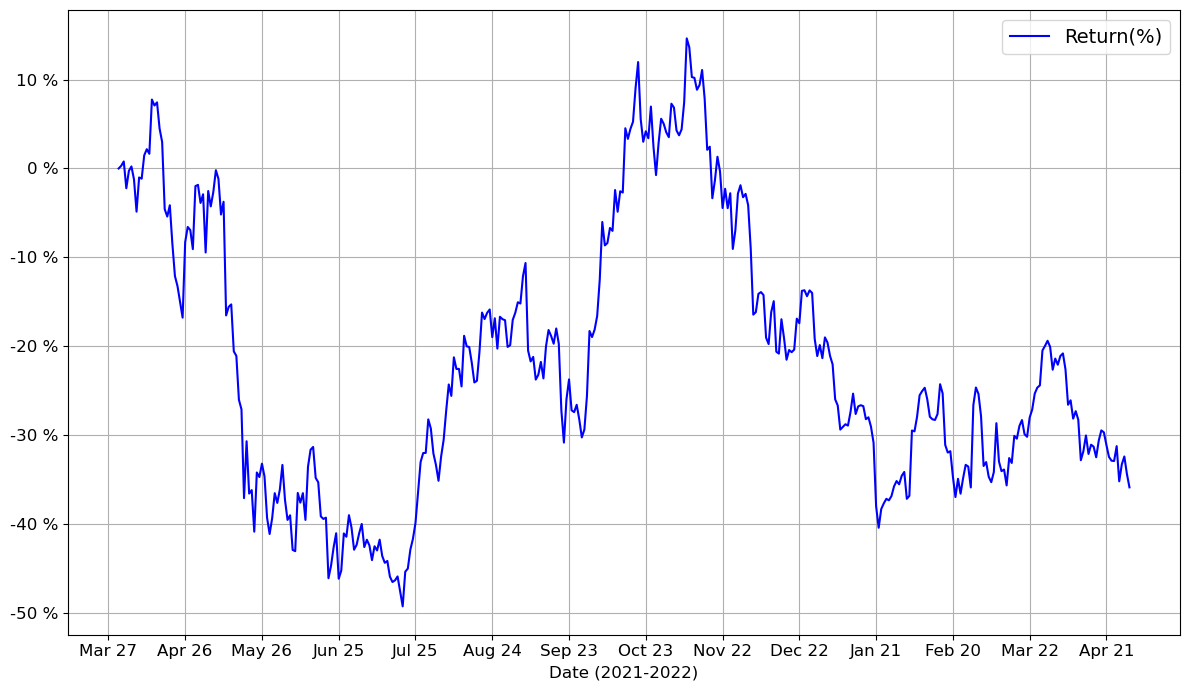

In [82]:
# Plotting the profit over time
plt.figure(figsize=(12, 7))
trade_df['date'] = pd.to_datetime(trade_df['date'])
plt.plot(trade_df['date'], trade_df['return_1'], label='Return(%)', color='blue')

def y_formatter(x, pos):
    return f'{int(x)} %'

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_formatter))


ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=0, ha='center',fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Date (2021-2022)',fontsize=12)
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

In [101]:
# Define the trading signal based on countinuous_sum_sigmoid
# Buy when countinuous_sum_sigmoid < threshold, Sell otherwise

threshold = -0.1

trade_df['signal'] = 'Sell'
trade_df.loc[trade_df['sentiment'] <= threshold, 'signal'] = 'Buy'

# Calculate profit/loss based on holding a product with a sentiment signal
trade_df

,date,price,sentiment,portfolio_1,profit_1,return_1,NumBitcoin_1,signal,portfolio_2,profit_2,return_2,NumBitcoin_2,portfolio_3,profit_3,return_3,NumBitcoin_3
0,2021-03-31,58918.83,-0.45,10000000.00,0.00,0.00,169,Buy,10000000.00,0.00,0.00,1,10000000.00,0.00,0.00,169.0
1,2021-04-01,59095.81,-0.48,10029909.62,29909.62,0.30,169,Buy,10000176.98,176.98,0.00,2,10029909.62,29909.62,0.30,169.0
2,2021-04-02,59384.31,-0.49,10078666.12,78666.12,0.79,169,Buy,10000753.98,753.98,0.01,3,10078666.12,78666.12,0.79,169.0
3,2021-04-03,57603.89,-0.59,9777775.14,-222224.86,-2.22,169,Buy,9995412.72,-4587.28,-0.05,4,9777775.14,-222224.86,-2.22,169.0
4,2021-04-04,58758.55,-0.62,9972912.68,-27087.32,-0.27,169,Buy,10000031.36,31.36,0.00,5,9972912.68,-27087.32,-0.27,169.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,2022-04-26,38117.46,-0.47,6484568.47,-3515431.53,-35.15,169,Buy,8198857.38,-1801142.62,-18.01,215,8621335.03,-1378664.97,-13.79,226.0
392,2022-04-27,39241.12,-0.47,6674467.01,-3325532.99,-33.26,169,Buy,8440444.28,-1559555.72,-15.60,215,8875282.19,-1124717.81,-11.25,226.0
393,2022-04-28,39773.83,-0.47,6764495.00,-3235505.00,-32.36,169,Buy,8554976.93,-1445023.07,-14.45,215,8995674.65,-1004325.35,-10.04,226.0
394,2022-04-29,38609.82,-0.47,6567777.31,-3432222.69,-34.32,169,Buy,8304714.78,-1695285.22,-16.95,215,8732608.39,-1267391.61,-12.67,226.0


In [102]:
trade_df['signal'].value_counts()

signal
Buy     394
Sell      2
Name: count, dtype: int64

### Strategy 1: Initially, you have $10,000,000, buy 1 bitcoin when the signal is good, sell 1 bitcoin if you have when the signal is bad. can't buy if you spent all the money, cant sell if you dont have bitcoin. calculate the profit and return every day.

In [104]:
initial_cash = 10000000
cash = initial_cash
btc = 0

portfolio_values = []
profits = []
returns = []
NumBTC = []

for _, row in trade_df.iterrows():
    price = row['price']
    signal = row['signal']

    # Buy 1 BTC if signal is 'buy' and you can afford it
    if signal == 'Buy' and cash >= price:
        cash -= price
        btc += 1

    # Sell 1 BTC if signal is 'sell' and you have BTC
    elif signal == 'Sell' and btc > 0:
        cash += price
        btc -= 1

    # Calculate portfolio value
    portfolio_value = cash + btc * price
    profit = portfolio_value - initial_cash
    ret = round(profit / initial_cash * 100, 2)

    portfolio_values.append(portfolio_value)
    profits.append(profit)
    returns.append(ret)
    NumBTC.append(btc)
    
# Add results back to the DataFrame
trade_df['portfolio_2'] = portfolio_values
trade_df['profit_2'] = profits
trade_df['return_2'] = returns
trade_df['NumBitcoin_2'] = NumBTC





trade_df

,date,price,sentiment,portfolio_1,profit_1,return_1,NumBitcoin_1,signal,portfolio_2,profit_2,return_2,NumBitcoin_2,portfolio_3,profit_3,return_3,NumBitcoin_3
0,2021-03-31,58918.83,-0.45,10000000.00,0.00,0.00,169,Buy,10000000.00,0.00,0.00,1,10000000.00,0.00,0.00,169.0
1,2021-04-01,59095.81,-0.48,10029909.62,29909.62,0.30,169,Buy,10000176.98,176.98,0.00,2,10029909.62,29909.62,0.30,169.0
2,2021-04-02,59384.31,-0.49,10078666.12,78666.12,0.79,169,Buy,10000753.98,753.98,0.01,3,10078666.12,78666.12,0.79,169.0
3,2021-04-03,57603.89,-0.59,9777775.14,-222224.86,-2.22,169,Buy,9995412.72,-4587.28,-0.05,4,9777775.14,-222224.86,-2.22,169.0
4,2021-04-04,58758.55,-0.62,9972912.68,-27087.32,-0.27,169,Buy,10000031.36,31.36,0.00,5,9972912.68,-27087.32,-0.27,169.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,2022-04-26,38117.46,-0.47,6484568.47,-3515431.53,-35.15,169,Buy,8198857.38,-1801142.62,-18.01,215,8621335.03,-1378664.97,-13.79,226.0
392,2022-04-27,39241.12,-0.47,6674467.01,-3325532.99,-33.26,169,Buy,8440444.28,-1559555.72,-15.60,215,8875282.19,-1124717.81,-11.25,226.0
393,2022-04-28,39773.83,-0.47,6764495.00,-3235505.00,-32.36,169,Buy,8554976.93,-1445023.07,-14.45,215,8995674.65,-1004325.35,-10.04,226.0
394,2022-04-29,38609.82,-0.47,6567777.31,-3432222.69,-34.32,169,Buy,8304714.78,-1695285.22,-16.95,215,8732608.39,-1267391.61,-12.67,226.0


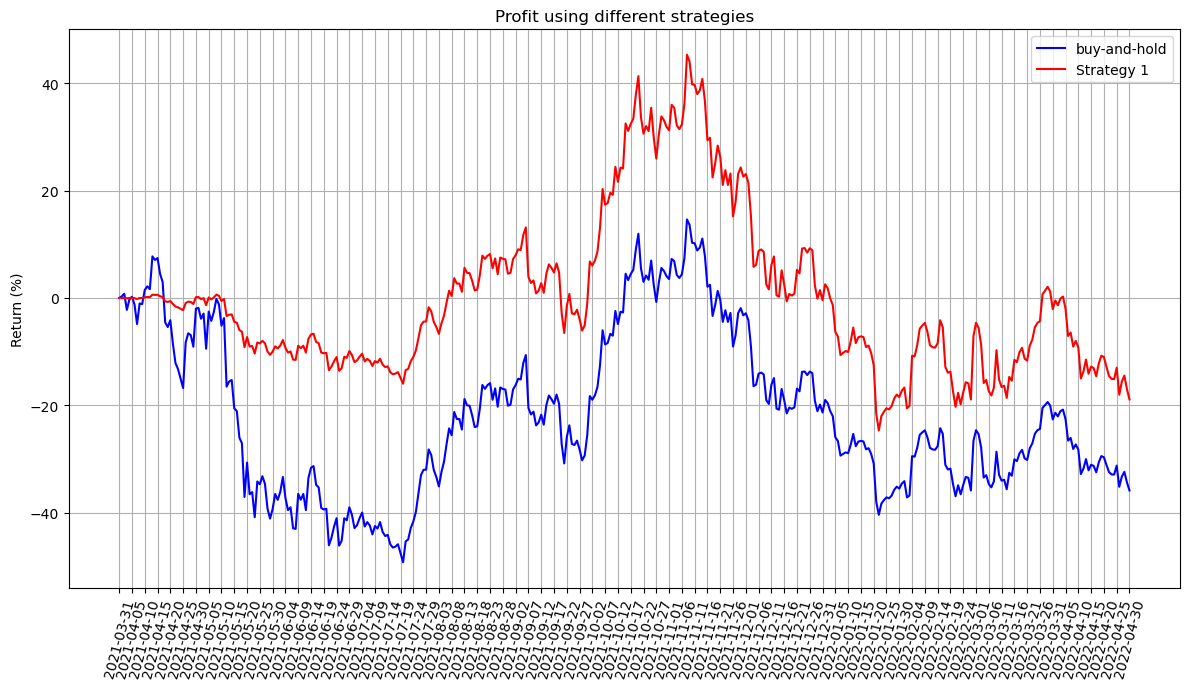

In [105]:
# Plotting the profit/loss over time
plt.figure(figsize=(12, 7))
plt.plot(trade_df['date'], trade_df['return_1'], label='buy-and-hold', color='blue')
plt.plot(trade_df['date'], trade_df['return_2'], label='Strategy 1', color='red')
#plt.plot(trade_df['date'], trade_df['NumBitcoin_2'], label='Number of BTC', color='green')
plt.title('Profit using different strategies')
plt.xticks(trade_df['date'][::5], rotation=75)
plt.ylabel('Return (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

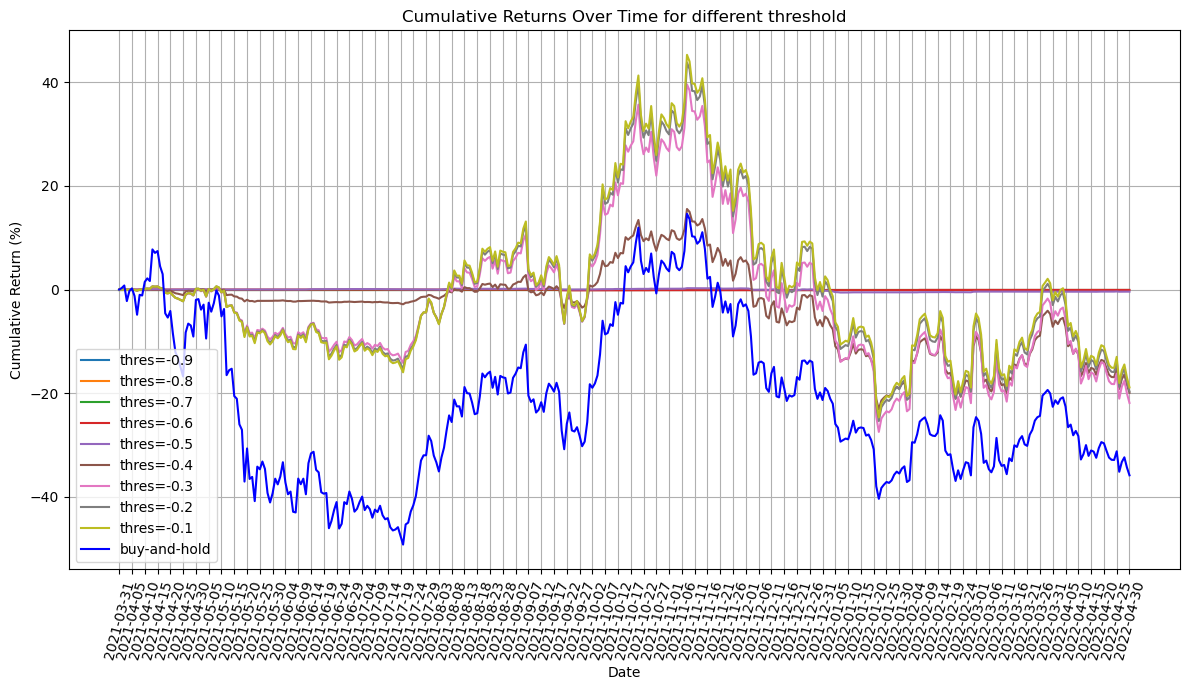

In [106]:
thresholds = np.arange(-0.9, 0.0, 0.1)
plt.figure(figsize=(12, 7))

for threshold in thresholds:
    trade_df['signal'] = 'Sell'
    trade_df.loc[trade_df['sentiment'] <= threshold, 'signal'] = 'Buy'
    
    initial_cash = 10000000
    cash = initial_cash
    btc = 0

    portfolio_values = []
    profits = []
    returns = []
    NumBTC = []

    for _, row in trade_df.iterrows():
        price = row['price']
        signal = row['signal']

        # Buy 1 BTC if signal is 'buy' and you can afford it
        if signal == 'Buy' and cash >= price:
            cash -= price
            btc += 1

        # Sell 1 BTC if signal is 'sell' and you have BTC
        elif signal == 'Sell' and btc > 0:
            cash += price
            btc -= 1

        # Calculate portfolio value
        portfolio_value = cash + btc * price
        profit = portfolio_value - initial_cash
        ret = round(profit / initial_cash * 100, 2)

        portfolio_values.append(portfolio_value)
        profits.append(profit)
        returns.append(ret)
        NumBTC.append(btc)
        
    # Add results back to the DataFrame
    trade_df['portfolio_2'] = portfolio_values
    trade_df['profit_2'] = profits
    trade_df['return_2'] = returns
    trade_df['NumBitcoin_2'] = NumBTC

    plt.plot(trade_df['date'], trade_df['return_2'], label=f"thres={threshold:.1f}")

# Add labels and grid
plt.plot(trade_df['date'], trade_df['return_1'], label='buy-and-hold', color='blue')
plt.title('Cumulative Returns Over Time for different threshold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.xticks(trade_df['date'][::5], rotation=75)
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()


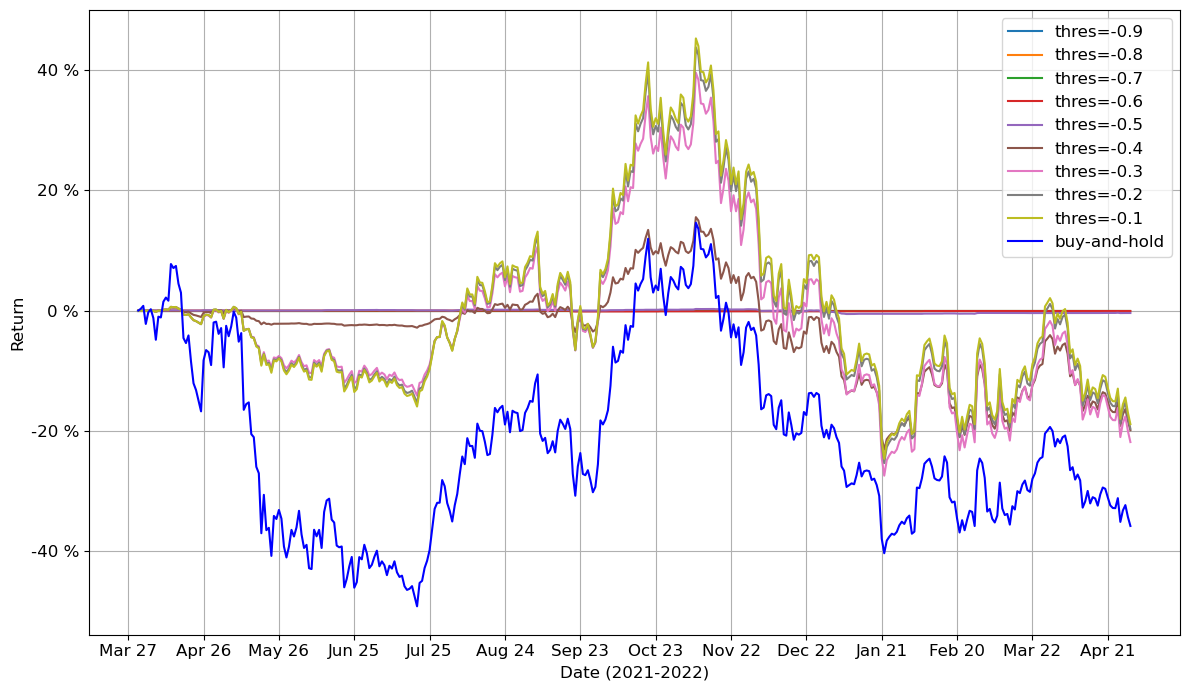

In [107]:
thresholds = np.arange(-0.9, 0.0, 0.1)
plt.figure(figsize=(12, 7))

for threshold in thresholds:
    trade_df['signal'] = 'Sell'
    trade_df.loc[trade_df['sentiment'] <= threshold, 'signal'] = 'Buy'
    
    initial_cash = 10000000
    cash = initial_cash
    btc = 0

    portfolio_values = []
    profits = []
    returns = []
    NumBTC = []

    for _, row in trade_df.iterrows():
        price = row['price']
        signal = row['signal']

        # Buy 1 BTC if signal is 'buy' and you can afford it
        if signal == 'Buy' and cash >= price:
            cash -= price
            btc += 1

        # Sell 1 BTC if signal is 'sell' and you have BTC
        elif signal == 'Sell' and btc > 0:
            cash += price
            btc -= 1

        # Calculate portfolio value
        portfolio_value = cash + btc * price
        profit = portfolio_value - initial_cash
        ret = round(profit / initial_cash * 100, 2)

        portfolio_values.append(portfolio_value)
        profits.append(profit)
        returns.append(ret)
        NumBTC.append(btc)
        
    trade_df['portfolio_2'] = portfolio_values
    trade_df['profit_2'] = profits
    trade_df['return_2'] = returns
    trade_df['NumBitcoin_2'] = NumBTC

    plt.plot(trade_df['date'], trade_df['return_2'], label=f"thres={threshold:.1f}")

plt.plot(trade_df['date'], trade_df['return_1'], label='buy-and-hold', color='blue')
def y_formatter(x, pos):
    return f'{int(x)} %'

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_formatter))


ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=0, ha='center',fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Return',fontsize=12)
plt.xlabel('Date (2021-2022)',fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## This is the returns for Strategy 1, the best threshold is -0.1. 

## Strategy 2: Initially, you have $10,000,000. Buy as much as you can when the signal is good, hold until the signal goes bad.

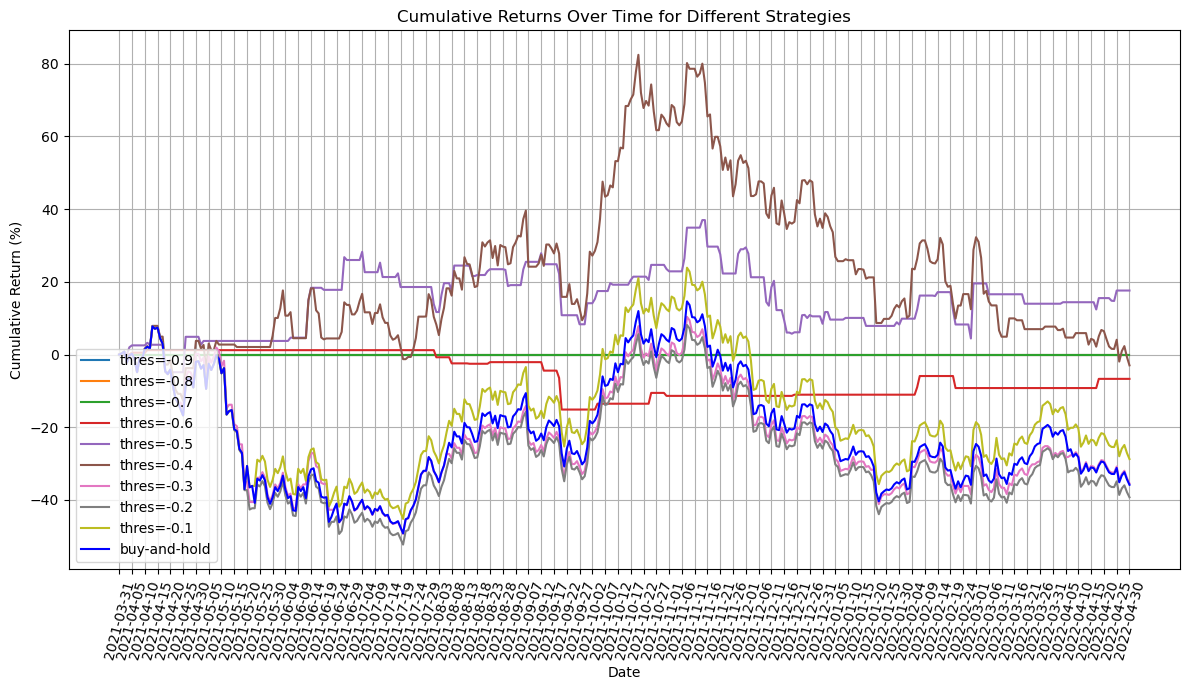

In [157]:
thresholds = np.arange(-0.9, 0.0, 0.1)
plt.figure(figsize=(12, 7))

for threshold in thresholds:
    trade_df['signal'] = 'Sell'
    trade_df.loc[trade_df['sentiment'] <= threshold, 'signal'] = 'Buy'


    start_money = 10000000
    cash = start_money
    holding = False  # Are we holding Bitcoin?
    btc_holding = 0        # How much BTC we hold
    trade_df['portfolio_3'] = 0.0
    trade_df['profit_3'] = 0.0
    trade_df['return_3'] = 0.0

    for i in range(len(trade_df)):
        price = trade_df.loc[i, 'price']
        signal = trade_df.loc[i, 'signal']
        
        if signal == 'Buy' and not holding:
            # Buy BTC with all available cash
            btc_holding = cash // price
            cash = cash - btc_holding * price
            holding = True
        
        elif signal == 'Sell' and holding:
            # Sell all BTC
            cash = cash + btc_holding * price
            btc_holding = 0
            holding = False
        
        # Calculate total portfolio value (cash + value of held BTC)
        current_value = cash + btc_holding * price
        trade_df.loc[i, 'portfolio_3'] = current_value
        trade_df.loc[i, 'profit_3'] = current_value - start_money
        trade_df.loc[i, 'return_3'] = round((current_value - start_money) / start_money * 100, 2)
        trade_df.loc[i, 'NumBitcoin_3'] = btc_holding

    plt.plot(trade_df['date'], trade_df['return_3'], label=f"thres={threshold:.1f}")

# Add labels and grid
plt.plot(trade_df['date'], trade_df['return_1'], label='buy-and-hold', color='blue')
plt.title('Cumulative Returns Over Time for Different Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.xticks(trade_df['date'][::5], rotation=75)
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()


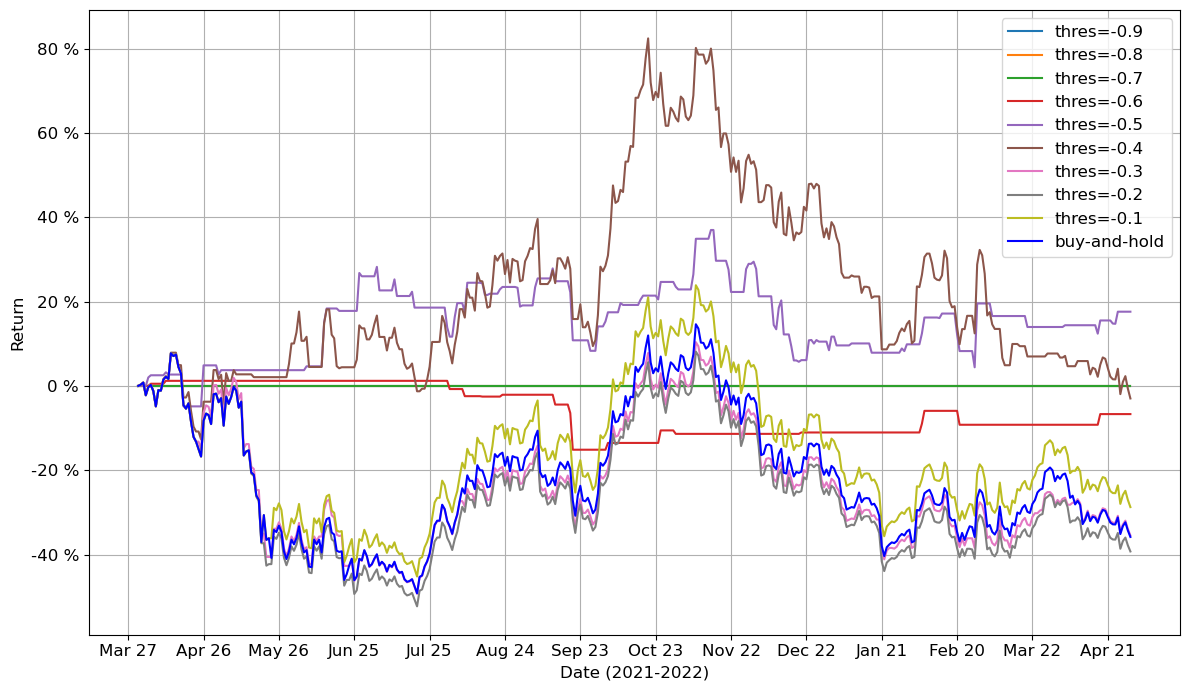

In [171]:
thresholds = np.arange(-0.9, 0.0, 0.1)
plt.figure(figsize=(12, 7))

for threshold in thresholds:
    trade_df['signal'] = 'Sell'
    trade_df.loc[trade_df['sentiment'] <= threshold, 'signal'] = 'Buy'


    start_money = 10000000
    cash = start_money
    holding = False  # Are we holding Bitcoin?
    btc_holding = 0        # How much BTC we hold
    trade_df['portfolio_3'] = 0.0
    trade_df['profit_3'] = 0.0
    trade_df['return_3'] = 0.0

    for i in range(len(trade_df)):
        price = trade_df.loc[i, 'price']
        signal = trade_df.loc[i, 'signal']
        
        if signal == 'Buy' and not holding:
            # Buy BTC with all available cash
            btc_holding = cash // price
            cash = cash - btc_holding * price
            holding = True
        
        elif signal == 'Sell' and holding:
            # Sell all BTC
            cash = cash + btc_holding * price
            btc_holding = 0
            holding = False
        
        # Calculate total portfolio value (cash + value of held BTC)
        current_value = cash + btc_holding * price
        trade_df.loc[i, 'portfolio_3'] = current_value
        trade_df.loc[i, 'profit_3'] = current_value - start_money
        trade_df.loc[i, 'return_3'] = round((current_value - start_money) / start_money * 100, 2)
        trade_df.loc[i, 'NumBitcoin_3'] = btc_holding

    plt.plot(trade_df['date'], trade_df['return_3'], label=f"thres={threshold:.1f}")

plt.plot(trade_df['date'], trade_df['return_1'], label='buy-and-hold', color='blue')
def y_formatter(x, pos):
    return f'{int(x)} %'

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_formatter))

ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=0, ha='center',fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Return',fontsize=12)
plt.xlabel('Date (2021-2022)',fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [131]:
trade_df

,date,price,sentiment,portfolio_1,profit_1,return_1,NumBitcoin_1,signal,portfolio_2,profit_2,return_2,NumBitcoin_2,portfolio_3,profit_3,return_3,NumBitcoin_3
0,2021-03-31,58918.83,-0.45,10000000.00,0.00,0.00,169,Buy,10000000.00,0.00,0.00,1,10000000.00,0.00,0.00,169.0
1,2021-04-01,59095.81,-0.48,10029909.62,29909.62,0.30,169,Buy,10000176.98,176.98,0.00,2,10029909.62,29909.62,0.30,169.0
2,2021-04-02,59384.31,-0.49,10078666.12,78666.12,0.79,169,Buy,10000753.98,753.98,0.01,3,10078666.12,78666.12,0.79,169.0
3,2021-04-03,57603.89,-0.59,9777775.14,-222224.86,-2.22,169,Buy,9995412.72,-4587.28,-0.05,4,9777775.14,-222224.86,-2.22,169.0
4,2021-04-04,58758.55,-0.62,9972912.68,-27087.32,-0.27,169,Buy,10000031.36,31.36,0.00,5,9972912.68,-27087.32,-0.27,169.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,2022-04-26,38117.46,-0.47,6484568.47,-3515431.53,-35.15,169,Buy,8198857.38,-1801142.62,-18.01,215,7200599.01,-2799400.99,-27.99,188.0
392,2022-04-27,39241.12,-0.47,6674467.01,-3325532.99,-33.26,169,Buy,8440444.28,-1559555.72,-15.60,215,7411847.09,-2588152.91,-25.88,188.0
393,2022-04-28,39773.83,-0.47,6764495.00,-3235505.00,-32.36,169,Buy,8554976.93,-1445023.07,-14.45,215,7511996.57,-2488003.43,-24.88,188.0
394,2022-04-29,38609.82,-0.47,6567777.31,-3432222.69,-34.32,169,Buy,8304714.78,-1695285.22,-16.95,215,7293162.69,-2706837.31,-27.07,188.0


In [174]:
threshold = -0.4

trade_df['signal'] = 'Sell'
trade_df.loc[trade_df['sentiment'] < threshold, 'signal'] = 'Buy'


start_money = 10000000
cash = start_money
holding = False  # Are we holding Bitcoin?
btc_holding = 0        # How much BTC we hold
trade_df['portfolio_3'] = 0.0
trade_df['profit_3'] = 0.0
trade_df['return_3'] = 0.0

for i in range(len(trade_df)):
    price = trade_df.loc[i, 'price']
    signal = trade_df.loc[i, 'signal']
    
    if signal == 'Buy' and not holding:
        # Buy BTC with all available cash
        btc_holding = cash // price
        cash = cash - btc_holding * price
        holding = True
    
    elif signal == 'Sell' and holding:
        # Sell all BTC
        cash = cash + btc_holding * price
        btc_holding = 0
        holding = False
    
    # Calculate total portfolio value (cash + value of held BTC)
    current_value = cash + btc_holding * price
    trade_df.loc[i, 'portfolio_3'] = current_value
    trade_df.loc[i, 'profit_3'] = current_value - start_money
    trade_df.loc[i, 'return_3'] = round((current_value - start_money) / start_money * 100, 2)
    trade_df.loc[i, 'NumBitcoin_3'] = btc_holding

#trade_df

In [175]:
trade_df['return_3'].describe()

count    396.000000
mean      21.881566
std       21.305048
min      -12.680000
25%        4.915000
50%       14.615000
75%       31.387500
max       82.430000
Name: return_3, dtype: float64

In [176]:
trade_df['signal'].value_counts()

signal
Buy     284
Sell    112
Name: count, dtype: int64

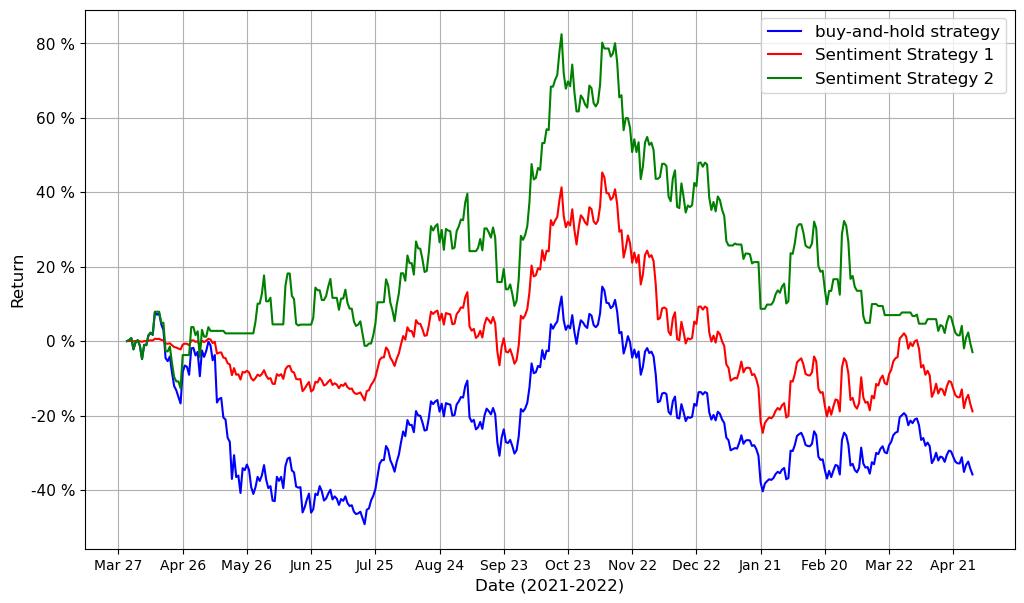

In [183]:
# Plot the cumulative profis
plt.figure(figsize=(12, 7))
plt.plot(trade_df['date'], trade_df['return_1'], label='buy-and-hold strategy', color='blue')
plt.plot(trade_df['date'], trade_df['return_2'], label='Sentiment Strategy 1', color='red')
plt.plot(trade_df['date'], trade_df['return_3'], label='Sentiment Strategy 2', color='green')
#plt.plot(trade_df['date'], trade_df['NumBitcoin_3'], label='BTC', color='purple')
def y_formatter(x, pos):
    return f'{int(x)} %'

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_formatter))

ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=0, ha='center',fontsize=10)
plt.yticks(fontsize=11)
plt.ylabel('Return',fontsize=12)
plt.xlabel('Date (2021-2022)',fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

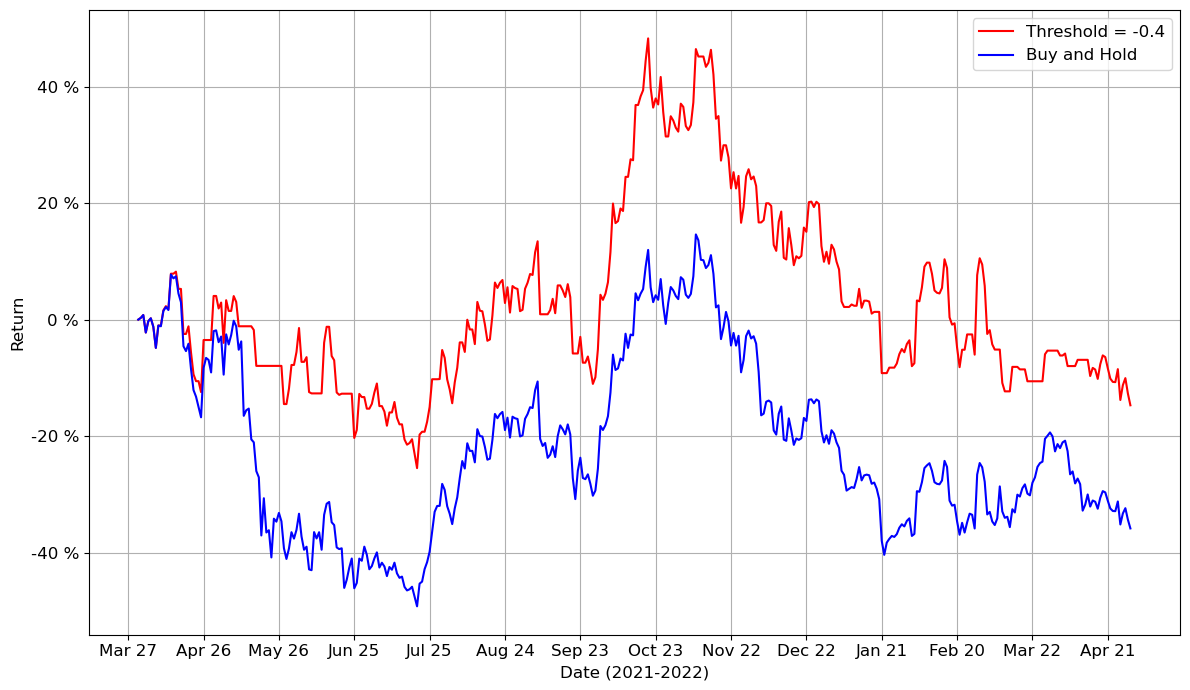

In [154]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

threshold = -0.4
trade_df['signal'] = 'Sell'
trade_df.loc[trade_df['sentiment'] <= threshold, 'signal'] = 'Buy'

start_money = 10000000
cash = start_money
holding = False
btc_holding = 0

trade_df['portfolio_3'] = 0.0
trade_df['profit_3'] = 0.0
trade_df['return_3'] = 0.0
trade_df['NumBitcoin_3'] = 0.0

for i in range(len(trade_df)):
    price = trade_df.loc[i, 'price']
    signal = trade_df.loc[i, 'signal']
    
    if signal == 'Buy' and not holding:
        btc_holding = cash // price
        cash -= btc_holding * price
        holding = True

    elif signal == 'Sell' and holding:
        cash += btc_holding * price
        btc_holding = 0
        holding = False

    current_value = cash + btc_holding * price
    trade_df.loc[i, 'portfolio_3'] = current_value
    trade_df.loc[i, 'profit_3'] = current_value - start_money
    trade_df.loc[i, 'return_3'] = round((current_value - start_money) / start_money * 100, 2)
    trade_df.loc[i, 'NumBitcoin_3'] = btc_holding

plt.figure(figsize=(12, 7))
plt.plot(trade_df['date'], trade_df['return_3'], label='Threshold = -0.4', color='red')
plt.plot(trade_df['date'], trade_df['return_1'], label='Buy and Hold', color='blue')

def y_formatter(x, pos):
    return f'{int(x)} %'

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_formatter))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.xticks(rotation=0, ha='center', fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Return', fontsize=12)
plt.xlabel('Date (2021-2022)', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
